In [3]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

## 1.加载数据

In [4]:
def loadDataSet(filename):
    '''加载数据'''
    X = []
    Y = []
    with open(filename, 'rb') as f:
        for idx, line in enumerate(f):
            line = line.decode('utf-8').strip()
            if not line:
                continue
                
            eles = line.split()
            if idx == 0:
                numFea = len(eles)
            eles = list(map(float, eles))
            
            X.append(eles[:-1])
            Y.append([eles[-1]])
    return np.array(X), np.array(Y)

## 2.标准化数据

In [5]:
def standarize(X):
    '''
    特征标准化处理：
    Args:
       X 样本集
    Returns:
      标准后的样本集
    '''
    m, n = X.shape
    values = {}  # 保存每一列的mean和std，便于对预测数据进行标准化
    for j in range(n):
        features = X[:,j]
        meanVal = features.mean(axis=0)
        stdVal = features.std(axis=0)
        values[j] = [meanVal, stdVal]
        if stdVal != 0:
            X[:,j] = (features - meanVal) / stdVal
        else:
            X[:,j] = 0
    return X, values
    

## 3.定义假设函数：
$$ h_\theta (X) = X \theta $$
$ X : m*n $ <br/>
$ \theta : n*1 $ <br/>
$ h_\theta(X)=Y : m * 1 $

In [6]:
def h(theta, X):
    '''定义函数模型'''
    return np.dot(X, theta)

## 4. 定义损失函数： $$ J(\theta_0,\theta_1,\theta_2,...,\theta_n) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2 $$

In [7]:
def J(theta, X, Y):
    '''定义损失函数'''
    m = len(X)
    return np.sum(np.dot((h(theta, X) - Y).T, (h(theta, X) - Y)) / (2 * m))

## 5. 定义梯度函数
梯度下降公式： $$ \theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)}) \cdot x_j^{(i)} $$
$ x_j^{(i)} : m*1 $ 即所有样本的第j列<br/>
$ h_\theta(x^{(i)}) - y^{(i)} : m * 1 $

In [8]:
def bgd(alpha, X, Y, maxloop, epsilon):
    '''定义梯度下降函数'''
    m, n = X.shape
    theta = np.zeros((n,1))  #初始化参数为0
    
    count = 0 # 记录迭代次数
    converged = False # 是否已收敛的标志
    cost = np.inf # 初始化代价值为无穷大
    costs = [J(theta, X, Y),] # 记录每一次的代价值
    
    thetas = {}  # 记录每一次参数的更新
    for i in range(n):
        thetas[i] = [theta[i,0],]
        
    while count <= maxloop:
        if converged:
            break
        count += 1
        
        # n个参数计算，并存入thetas中
        for j in range(n):
            deriv = np.sum(np.dot(X[:,j].T, (h(theta, X) - Y))) / m
            thetas[j].append(theta[j,0] - alpha*deriv)
            
        # n个参数在当前theta中更新  
        for j in range(n):
            theta[j,0] = thetas[j][-1]
            
        # 记录当前参数的函数代价，并存入costs
        cost = J(theta, X, Y)
        costs.append(cost)
            
        if abs(costs[-1] - costs[-2]) < epsilon:
            converged = True
    
    return theta, thetas, costs

## 测试一下
1.加载数据

In [10]:
originX, Y = loadDataSet('./data/houses.txt')
print(originX.shape, Y.shape)

(47, 2) (47, 1)


2.数据预处理

In [34]:
# 对特征X增加x0列
m,n = originX.shape
X, values = standarize(originX.copy())
X = np.concatenate((np.ones((m,1)), X), axis=1)
print(X.shape, Y.shape)
print(X[:3],values)

(47, 3) (47, 1)
[[ 1.         -0.50331285 -0.52262577]
 [ 1.         -0.41377247  0.59389292]
 [ 1.         -0.62288038 -0.52262577]] {0: [81.07574468085106, 36.96655980199384], 1: [2.4680851063829787, 0.895641071482944]}


3.模型学习

In [35]:
alpha = 1 # 学习率
maxloop = 5000 # 最大迭代次数
epsilon = 0.000001
X.shape

(47, 3)

In [36]:
resault = bgd(alpha, X, Y, maxloop, epsilon)
theta , thetas, costs = resault
# print(theta, thetas, costs)

4.预测价格

In [37]:
normalizedSize = (70-values[0][0])/values[0][1]
normalizedBr = (2-values[1][0])/values[1][1]
predicateX = np.matrix([[1, normalizedSize, normalizedBr]])
price = h(theta, predicateX)
print('70㎡两居估价: ￥%.4f万元'%price)

70㎡两居估价: ￥235.9858万元


5.绘制拟合平面

Using matplotlib backend: Qt5Agg


Text(0.5,0,'估价')

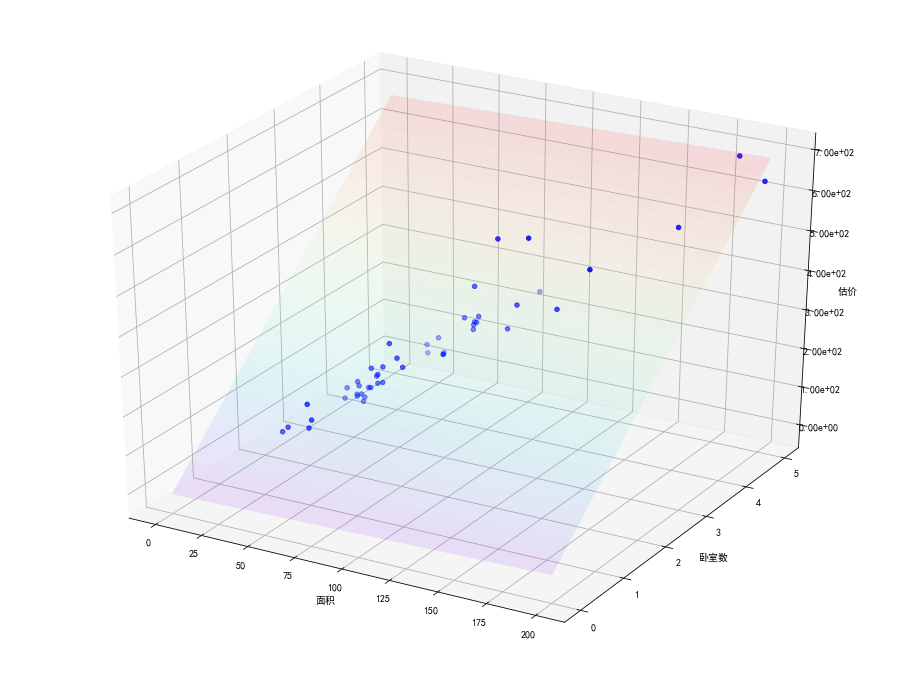

In [38]:
%matplotlib
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import matplotlib.ticker as mtick

# 打印拟合平面
fittingFig = plt.figure(figsize=(16, 12))
title = 'bgd: rate=%.3f, maxloop=%d, epsilon=%.3f \n'%(alpha,maxloop,epsilon)
ax=fittingFig.gca(projection='3d')

xx = np.linspace(0,200,25)
yy = np.linspace(0,5,25)
zz = np.zeros((25,25))
for i in range(25):
    for j in range(25):
        normalizedSize = (xx[i]-values[0][0])/values[0][1]
        normalizedBr = (yy[j]-values[1][0])/values[1][1]
        x = np.matrix([[1,normalizedSize, normalizedBr]])
        zz[i,j] = h(theta, x)
xx, yy = np.meshgrid(xx,yy)
ax.zaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap=cm.rainbow, alpha=0.1, antialiased=True)

xs = originX[:, 0].flatten()
ys = originX[:, 1].flatten()
zs = Y[:, 0].flatten()
ax.scatter(xs, ys, zs, c='b', marker='o')

ax.set_xlabel(u'面积')
ax.set_ylabel(u'卧室数')
ax.set_zlabel(u'估价')

#plt.show()

Text(0,0.5,'代价函数')

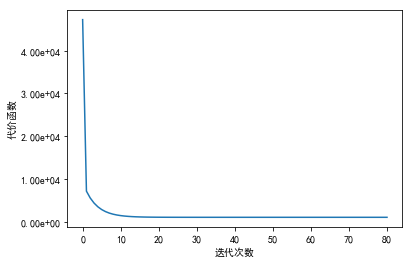

In [39]:
%matplotlib inline
errorsFig = plt.figure()
ax = errorsFig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

ax.plot(range(len(costs)), costs)
ax.set_xlabel(u'迭代次数')
ax.set_ylabel(u'代价函数')